In [1]:
from bokeh.models import ColumnDataSource, HoverTool, LinearAxis, Range1d, FactorRange
from bokeh.plotting import figure
from bokeh.io import show, output_file
import pandas as pd
import math
from decimal import Decimal
import numpy

df = pd.read_csv('../data/global_food_prices.csv')
df_ref = pd.read_csv('../data/refugee_data.csv')
df_ex = pd.read_csv('../data/exchange_rates_to_us_dollar.csv')

In [2]:
df_ref = df_ref[df_ref['country_of_asylum']=='Afghanistan']
df = df[(df['country']=='Afghanistan') & (df['product']=='Bread')]
years = sorted(list(set(df['year'])))


df_ref = df_ref[df_ref['year'].isin(years)]

refugee_count = []
yearly_prices = []
for year in years:
    subset_ref = df_ref[df_ref['year']==year]
    refugee_count.append(sum(list(set(subset_ref['amount_of_refugees']))))
    
    subset_prc = df[df['year']==year]
    prices = [float(x) if x != 'UNKNOWN' else 0 for x in list(set(subset_prc['price_in_dollars']))]
    yearly_prices.append(sum(prices) / len(prices))

tups = zip(refugee_count, yearly_prices)
tups = sorted(tups, key=lambda tups: tups[0])
tups = list(zip(*tups))
p = figure()

p.line(list(tups[0]), list(tups[1]))

show(p)

#df[df['year']==2017]

In [95]:
df2 = df[(df['country']=='Afghanistan') & (df['product']=='Bread')]
years = sorted(list(set(df2['year'])))
ref2 = df_ref[(df_ref['country_of_asylum']=='Afghanistan') & (df_ref['year'].isin(years))]
years = sorted(list(set(ref2['year'])))

output_file('../graphs/relation_refugees_bread_prices_afghanistan.html')
print(years)
prices = []
refs = []
for year in years:
    s = df2[df2['year']==year]
    p = [float(x) if x != 'UNKNOWN' else 0 for x in list(s['price_in_dollars'])]
    prices.append(sum(p) / len(p))
    s = ref2[ref2['year']==year]
    r = sum(list(s['amount_of_refugees']))
    refs.append(r)

p = figure()
p.extra_y_ranges = {'refs': Range1d(start=0, end = 300000)}
p.add_layout(LinearAxis(y_range_name='refs', axis_label='Amount of refugees'), 'right')
p.y_range = Range1d(0.5, 2)
p.line(years, prices, legend='Bread price')
p.line(years, refs, y_range_name='refs', line_color='orange', legend='Amount of refugees')
p.xaxis.axis_label="Years"
p.yaxis.axis_label="Price in US Dollars"
p.legend.location='top_right'
p.legend.click_policy='hide'
p.title.text = "Amount of refugees (right) entering {} compared to average {} price".format("Afghanistan", "Bread")
show(p)

print(correlation(prices,refs))

[2014.0, 2015.0, 2016.0]
0.3669140428704803


In [29]:
def price_to_kg(price, unit):
    to_kg = {'KG': 1, 'Unit': 1, '500 G': 2, '400 G': 2.5, '150 G': 6.6666667, 'Pound': 2.20462262}
    return price * to_kg[unit]

# Currency Exchange Scatter Plot

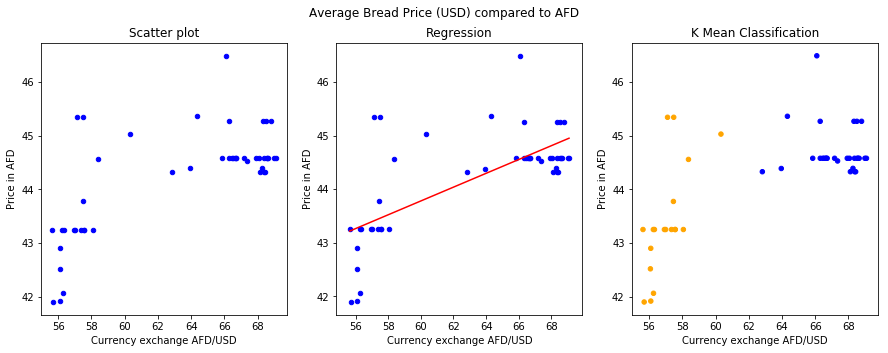

In [94]:
dfs = df[(df['country']=='Afghanistan') & (df['product']=='Bread')]
currency = list(df['currency'])[0]
years = sorted(list(set(dfs['year'])))
exs = df_ex[(df_ex['currency']==currency) & (df_ex['year'].isin(years))]


output_file('../graphs/corrolation_food_price_currency_value.html')

rate = []
price = []
for year in years:
    dfss = dfs[dfs['year']==year]
    months = sorted(list(set(dfss['month'])))
    for month in months:
        rate.append(list(exs[(exs['year']==year) & (exs['month']==month)]['value'])[0])
        p = list(dfss[dfss['month']==month]['avg_price'])[0]
        p = p if p != 'UNKNOWN' else None
        price.append(p)


price = [float(x) if x != None else None for x in price]
rate = [float(x) if x != None else None for x in rate]


s = zip(rate, price)
s = sorted(s, key=lambda s: s[0])
s = list(zip(*s))

xv = interpolate(list(s[0]))
yv = interpolate(list(s[1]))


print(correlation(xv,yv))

q = figure()
q.circle(xv, yv, size=5)
q.y_range = Range1d(40, 48)
q.title.text = "Relation Bread Price with Afghanistan Valuta value in USD "
q.xaxis.axis_label="Currenct exchange: 1 AFD to USD"
q.yaxis.axis_label="Bread Price"
q.x_range = Range1d(min(rate), max(rate))
show(q)


k = pd.DataFrame()
k['exchange'] = xv
k['breadprice'] = yv

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
import sklearn.metrics as sm

model = KMeans(n_clusters=2)
model.fit(k)

model.labels_

X = np.vstack(xv)
X = np.column_stack((X, np.ones(X.shape[0])))
Y = yv
a, b = np.linalg.lstsq(X, Y)[0]
xline = [a * x + b for x in xv]

plt.figure(figsize=(15,5))

plt.suptitle("Average Bread Price (USD) compared to AFD ")

# Create a colormap
colormap = np.array(['orange', 'blue'])

# Plot the Original Classifications
ax1 = plt.subplot(1, 3, 1)
plt.scatter(xv, yv, c='blue', s=20)
plt.title('Scatter plot')

# Plot the Original Classifications
ax2 = plt.subplot(1, 3, 2)
plt.plot(xv, xline, c ='red')
plt.scatter(xv, yv, c='blue', s=20)
plt.title('Regression')
 
# Plot the Models Classifications
ax3 = plt.subplot(1, 3, 3)
plt.scatter(xv, yv, c=colormap[model.labels_], s=20)
plt.title('K Mean Classification')
predY = model.labels_

ax1.set_ylabel('Price in AFD')
ax2.set_ylabel('Price in AFD')
ax3.set_ylabel('Price in AFD')

ax1.set_xlabel('Currency exchange AFD/USD')
ax2.set_xlabel('Currency exchange AFD/USD')
ax3.set_xlabel('Currency exchange AFD/USD')

plt.savefig('../graphs/BreadPriceValutaComparison_MachineLearning.png', bbox_inches='tight')

In [22]:
def interpolate(values):
    for i in range(len(values)):
        if values[i] == None:
            ii = i
            x = None
            while x == None:
                ii -= 1
                if ii < 0: x = values[i]
                x = values[ii]
            ii = i
            y = None
            while y == None:
                ii -= 1
                if ii >= len(values): y = values[i]
                y = values[ii]
            values[i] = (x + y) / 2
    return values
                
def max_none(values):
    m = values[0]
    for value in values:
        if value != None and value > m:
            m = value
    return m

In [31]:
def average(x):
    return float(sum(x)) / len(x)

def correlation(x, y):
    n = len(x)
    avg_x = average(x)
    avg_y = average(y)
    dif = 0
    xdif2 = 0
    ydif2 = 0
    for i in range(n):
        xdif = x[i] - avg_x
        ydif = y[i] - avg_y
        dif += xdif * ydif
        xdif2 += xdif * xdif
        ydif2 += ydif * ydif
    return dif / math.sqrt(xdif2 * ydif2)

In [24]:
df2 = df[(df['country']=='Afghanistan') & (df['product']=='Bread')]
years = sorted(list(set(df2['year'])))

y = []
p = []
for year in years:
    s = df2[df2['year']==year]
    months = sorted(list(set(s['month'])))
    for month in months:
        y.append((str(year), str(month)))
        p.append(list(s[s['month']==month]['price_in_dollars'])[0])
p = [float(x) if x != 'UNKNOWN' else None for x in p]
p = interpolate(p)

s = figure(width=700, height=400, x_range=FactorRange(*y))

s.title.text = "Average Bread (per KG) price in USD for Afghanistan"
s.xaxis.axis_label="Time"
s.yaxis.axis_label="Price in USD/KG"
s.line(y, p)

show(s)

In [25]:
def univariate_non_graphical(data):
    data.sort()
    mean = sum(data) / len(data)
    median = data[int(len(data) // 2) - 1]
    dif = 0
    for x in data:
        xdif = x - mean
        dif += xdif * xdif
    variance = dif / (len(data) - 1)    
    standard_deviation = math.sqrt(variance)
    print("mean     : {}".format(round(mean, 2)))
    print("median   : {}".format(round(median, 2)))
    print("variance : {}".format(round(variance, 3)))
    print("sd       : {}".format(round(standard_deviation, 2)))
    
univariate_non_graphical(p)

mean     : 0.71
median   : 0.68
variance : 0.003
sd       : 0.05
